### **E-mail Classification and Spam Generation applying ML and DL models**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

### Data loading

In [4]:
df = pd.read_csv('SpamvsHam.tsv', sep = '\t', names = ['label', 'text'])

In [ ]:
df.head()

In [236]:
df.isnull().sum()

label    0
text     0
dtype: int64

### Data preprocessing

#### Convert label type to integer

In [3]:
label_dic = {'ham': 0, 'spam': 1}
labels = np.array([label_dic[i] for i in df['label']])

#### Text preprocessing

In [4]:
def preprocess_text(data):
    stop_words = set(stopwords.words('english'))
    table = str.maketrans('', '', string.punctuation)
    lemmatizer = WordNetLemmatizer()
    preprocessed_text_t = []
    preprocessed_text_w = []
    for text in data:
        text = text.lower()
        text = text.translate(table)
        text = text.split()
        text = [word for word in text if word not in stop_words]
        text = [lemmatizer.lemmatize(word) for word in text]
        preprocessed_text_t.append(' '.join(text))
        preprocessed_text_w.append(text)
    return preprocessed_text_t, preprocessed_text_w

In [5]:
preprocessed_text_t, preprocessed_text_w = preprocess_text(df['text'])

#### Extract features through TF-IDF and Word2Vec

##### TfidfVectorizer

In [6]:
def tfidf_data(data):
    tfidf = TfidfVectorizer(max_features = 100, decode_error = 'ignore', tokenizer = None, lowercase = False, min_df = 2)
    data_tfidf = tfidf.fit_transform(data)
    data_tfidf = data_tfidf.toarray()
    return data_tfidf, tfidf

In [7]:
preprocessed_text_tfidf, tfidf_model = tfidf_data(preprocessed_text_t)

##### Word2Vec

In [8]:
def word2vec_data(data):
    word2vec_model = Word2Vec(sentences = data, vector_size = 100, window = 5, min_count = 1, workers = 5)
    data_wv = np.array([np.mean([word2vec_model.wv[word] for word in seq if word in word2vec_model.wv] or [np.zeros(100)], axis = 0) for seq in data])

    return data_wv, word2vec_model

In [9]:
preprocessed_text_wv, word2vec_model = word2vec_data(preprocessed_text_w)


#### Concatenate features

#### Combine word embedding

In [10]:
preprocessed_text_combined = np.concatenate((preprocessed_text_wv, preprocessed_text_tfidf), axis = 1)

#### Split data into training and testing set

In [13]:
text_train_combined, text_test_combined, label_train_combined, label_test_combined = train_test_split(preprocessed_text_combined, labels,
                                                                    train_size = 0.8, random_state = 30)

#### Balance training data

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'auto', random_state = 30)

text_train_combined, label_train_combined = smote.fit_resample(text_train_combined, label_train_combined)

### Machine learning models for text classification

In [15]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB

#### Model building

##### Gussian Naive Bayes

In [16]:
def build_GNB_model(data_train, label_train, data_test, label_test):

    time_start = datetime.now()

    model = GaussianNB()
    model.fit(data_train, label_train)
    label_pred = model.predict(data_test)
    accuracy = accuracy_score(label_pred, label_test)

    time_end = datetime.now()
    time = (time_end - time_start).total_seconds()

    print('Accuracy:', accuracy)
    print('Time:', time)
    return model, accuracy, time

##### Multinomial Naive Bayes

In [17]:
def build_MNB_model(data_train, label_train, data_test, label_test):
    
    scaler = MinMaxScaler()
    data_train = scaler.fit_transform(data_train)
    data_test = scaler.transform(data_test)

    time_start = datetime.now()

    model = MultinomialNB()
    model.fit(data_train, label_train)
    label_pred = model.predict(data_test)
    accuracy = accuracy_score(label_pred, label_test)

    time_end = datetime.now()
    time = (time_end - time_start).total_seconds()

    print('Accuracy:', accuracy)
    print('Time:', time)
    return model, accuracy, time

##### Support vector machine

In [18]:
from sklearn import svm

In [19]:
def build_svm_model(data_train, label_train, data_test, label_test):

    param_grid = {'C': [0.1, 1, 10, 100], 
                  'gamma': [0.001, 0.01, 0.1], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

    model = svm.SVC()
    rd_search = RandomizedSearchCV(model, param_grid, n_iter = 5, verbose = 1, random_state = 30)
    rd_search.fit(data_train, label_train)
    best_params = rd_search.best_params_

    time_start = datetime.now()

    best_model = svm.SVC(C = best_params['C'], gamma = best_params['gamma'], kernel = best_params['kernel'], random_state = 30)
    best_model.fit(data_train, label_train)
    label_pred = best_model.predict(data_test)
    accuracy = accuracy_score(label_pred, label_test)

    time_end = datetime.now()
    time = (time_end - time_start).total_seconds()

    print('Accuracy:', accuracy)
    print('Time:', time)
    return best_model, accuracy, time

##### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
def build_random_forest_model(data_train, label_train, data_test, label_test):

    model = RandomForestClassifier()

    param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss'] }

    rd_search = RandomizedSearchCV(model, param_grid, n_iter = 5, random_state = 30, verbose = 1)
    rd_search.fit(data_train, label_train)
    best_params = rd_search.best_params_

    time_start = datetime.now()
    best_model = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'],
                                        min_samples_split = best_params['min_samples_split'], min_samples_leaf = best_params['min_samples_leaf'])

    best_model.fit(data_train, label_train)
    label_pred = best_model.predict(data_test)
    accuracy = accuracy_score(label_pred, label_test)

    time_end = datetime.now()
    time = (time_end - time_start).total_seconds()

    print('Accuracy:', accuracy)
    print('Time:', time)
    return best_model, accuracy, time

##### KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
def build_KNC_model(data_train, label_train, data_test, label_test):
    model = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': [i for i in range(1, 10)],
        'p': [1, 2]
    }

    rd_search = RandomizedSearchCV(model, param_grid, n_iter = 5, verbose = 1, random_state = 30)
    rd_search.fit(data_train, label_train)

    best_params = rd_search.best_params_

    time_start = datetime.now()

    best_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], p = best_params['p'])
    best_model.fit(data_train, label_train)
    label_pred = best_model.predict(data_test)
    accuracy = accuracy_score(label_pred, label_test)

    time_end = datetime.now()
    time = (time_end - time_start).total_seconds()

    print('Accuracy:', accuracy)
    print('Time:', time)
    return best_model, accuracy, time

##### LightGBM

In [24]:
from lightgbm import LGBMClassifier

In [25]:
def build_LGBM_model(data_train, label_train, data_test, label_test):
    model = LGBMClassifier()
    param_grid = {
        'learning_rate': [0.01, 0.1, 1],
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'num_leaves': [20, 30, 40, 50],
        'subsample': [0.8, 0.9, 1.0],
        }

    rd_search = RandomizedSearchCV(model, param_grid, n_iter = 5, random_state = 30, verbose = 1)
    rd_search.fit(data_train, label_train)
    best_params = rd_search.best_params_

    time_start = datetime.now()

    best_model = LGBMClassifier(learning_rate = best_params['learning_rate'], n_estimators = best_params['n_estimators'],
                                max_depth = best_params['max_depth'], num_leaves = best_params['num_leaves'],
                                subsample = best_params['subsample'])
    best_model.fit(data_train, label_train)
    label_pred = best_model.predict(data_test)
    accuracy = accuracy_score(label_pred, label_test)

    time_end = datetime.now()
    time = (time_end - time_start).total_seconds()

    print('Accuracy:', accuracy)
    print('Time:', time)
    return best_model, accuracy, time

##### XGBoost

In [26]:
from xgboost import XGBClassifier

In [27]:
def build_XGB_model(data_train, label_train, data_test, label_test):
    model = XGBClassifier()
    param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
    }

    rd_search = RandomizedSearchCV(model, param_grid, n_iter = 5, random_state = 30, verbose = 1)
    rd_search.fit(data_train, label_train)
    best_params = rd_search.best_params_

    time_start = datetime.now()

    best_model = XGBClassifier(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'])
    best_model.fit(data_train, label_train)
    label_pred = best_model.predict(data_test)
    accuracy = accuracy_score(label_pred, label_test)

    time_end = datetime.now()
    time = (time_end - time_start).total_seconds()

    print('Accuracy:', accuracy)
    print('Time:', time)
    return best_model, accuracy, time

#### Model training

In [28]:
import random as rn

In [ ]:
np.random.seed(30)
rn.seed(30)

model_name = ['GaussianNB', 'MultinomialNB', 'SVM', 'Random Forest', 'KNN', 
              'LGBMClassifier', 'XGBClassifier']
model_ml = [build_GNB_model, build_MNB_model, build_svm_model, build_random_forest_model,
            build_KNC_model, build_LGBM_model, build_XGB_model]

accuracy_ml_c = []
time_ml_c = []
predictions_ml_c = {}
model_dict_c = {}

i = 0
for m in (model_ml):
    print(model_name[i])
    best_model, accuracy, time = m(text_train_combined, label_train_combined, text_test_combined, label_test_combined)
    model_dict_c[model_name[i]] = best_model
    predictions = best_model.predict(text_test_combined)
    predictions_ml_c[model_name[i]] = predictions
    accuracy_ml_c.append(accuracy)
    time_ml_c.append(time)
    print(' ')
    i += 1

#### F1, recall, precision visualization

In [152]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [177]:
result_ml_1 = {}

score_1 = [precision_score(label_test_combined, predictions_ml_c[p]) for p in predictions_ml_c] + [recall_score(label_test_combined, predictions_ml_c[p]) for p in predictions_ml_c] + [f1_score(label_test_combined, predictions_ml_c[p]) for p in predictions_ml_c]
result_ml_1 = {'Model': model_name * 3, 'Score 1': score_1, 'Score Type': ['Precision'] * 7 + ['Recall'] * 7 + ['F1 score'] * 7}
result_ml_1 = pd.DataFrame(result_ml_1)

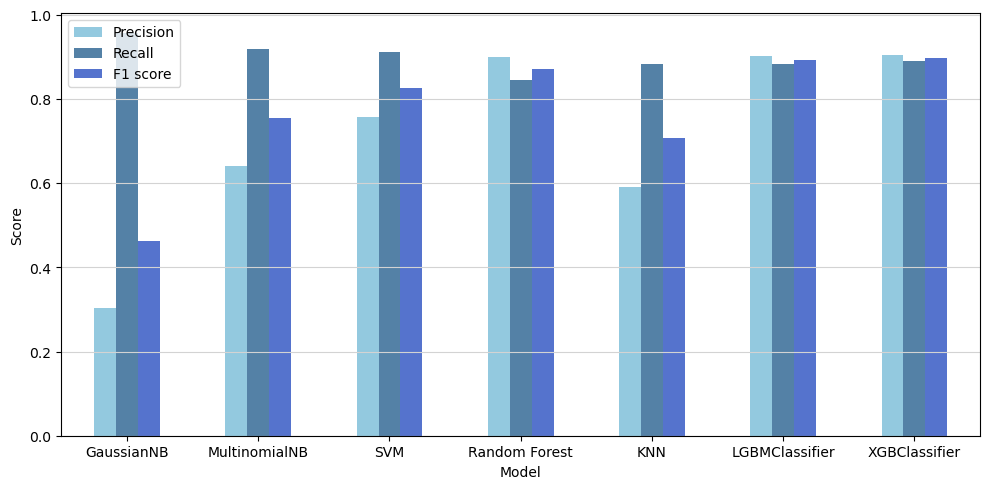

In [179]:
plt.figure(figsize = (10, 5))
plt.grid(color = 'lightgray', axis = 'y')
sns.barplot(x = 'Model', y = 'Score 1', data = result_ml_1, hue = 'Score Type', palette = ['skyblue', 'steelblue', 'royalblue'], width = 0.5)
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(fontsize = 10)
plt.tight_layout()
plt.show()

### Deep learning models for text classification

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, Dropout, LSTM, Bidirectional, LayerNormalization, Attention, GRU, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import random as rn
from kerastuner import RandomSearch

In [34]:
text_train_combined_3d = text_train_combined.reshape(text_train_combined.shape[0], 1, text_train_combined.shape[1])
text_test_combined_3d = text_test_combined.reshape(text_test_combined.shape[0], 1, text_test_combined.shape[1])

#### Model building

##### CNN-BiGRU

In [35]:
def build_bigru_model(hp):
        inputs = Input(shape = (text_train_combined_3d.shape[1], text_train_combined_3d.shape[2]))
        conv1d = Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(inputs)
        gru = Bidirectional(GRU(units = hp.Choice('n1', values = [64, 128]), dropout = hp.Choice('dr', values = [0.2, 0.3, 0.4]), recurrent_dropout = hp.Choice('rdr', values = [0.2, 0.3, 0.4]), activation = hp.Choice('activation', values = ['relu', 'tanh']), return_sequences = False))(conv1d)
        dense = Dense(hp.Choice('n2', values = [32, 64]), activation = hp.Choice('activation', values = ['relu', 'tanh']))(gru)
        layernorm = LayerNormalization()(dense)
        dropout = Dropout(hp.Choice('dr2', values = [0.2, 0.3, 0.4]))(layernorm)
        outputs = Dense(1, activation = 'sigmoid')(dropout)
        model = Model(inputs = inputs, outputs = outputs)
        
        optimizer_choice = hp.Choice('optimizer', values = ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta'])
    
        if optimizer_choice == 'adam':
                optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice('lr_adam', values = [0.001, 0.01]))
        elif optimizer_choice == 'rmsprop':
                optimizer = tf.keras.optimizers.RMSprop(learning_rate = hp.Choice('lr_rmsprop', values = [0.001, 0.01]))
        elif optimizer_choice == 'sgd':
                optimizer = tf.keras.optimizers.SGD(learning_rate = hp.Choice('lrsgd', values = [0.001, 0.01]))
        elif optimizer_choice == 'adagrad':
                optimizer = tf.keras.optimizers.Adagrad(learning_rate = hp.Choice('lr_adagrad', values = [0.001, 0.01]))
        else:
                optimizer = tf.keras.optimizers.Adadelta(learning_rate = hp.Choice('lr adadelta', values = [0.001, 0.01]))
    
        model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
        return model

##### CNN-BiLSTM

In [36]:
def build_bilstm_model(hp):
        inputs = Input(shape = (text_train_combined_3d.shape[1], text_test_combined_3d.shape[2]))
        conv1d = Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(inputs)
        lstm = Bidirectional(LSTM(units = hp.Choice('n1', values = [64, 128]), dropout = hp.Choice('dr', values = [0.2, 0.3, 0.4]), recurrent_dropout = hp.Choice('rdr', values = [0.2, 0.3, 0.4]), activation = hp.Choice('activation', values = ['relu', 'tanh']), return_sequences = False))(conv1d)
        dense = Dense(hp.Choice('n2', values = [32, 64]), activation = hp.Choice('activation', values = ['relu', 'tanh']))(lstm)
        layernorm = LayerNormalization()(dense)
        dropout = Dropout(hp.Choice('dr2', values = [0.2, 0.3, 0.4]))(layernorm)
        outputs = Dense(1, activation = 'sigmoid')(dropout)
        model = Model(inputs = inputs, outputs = outputs)
        
        optimizer_choice = hp.Choice('optimizer', values = ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta'])
    
        if optimizer_choice == 'adam':
                optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice('lr_adam', values = [0.001, 0.01]))
        elif optimizer_choice == 'rmsprop':
                optimizer = tf.keras.optimizers.RMSprop(learning_rate = hp.Choice('lr_rmsprop', values = [0.001, 0.01]))
        elif optimizer_choice == 'sgd':
                optimizer = tf.keras.optimizers.SGD(learning_rate = hp.Choice('lrsgd', values = [0.001, 0.01]))
        elif optimizer_choice == 'adagrad':
                optimizer = tf.keras.optimizers.Adagrad(learning_rate = hp.Choice('lr_adagrad', values = [0.001, 0.01]))
        else:
                optimizer = tf.keras.optimizers.Adadelta(learning_rate = hp.Choice('lr adadelta', values = [0.001, 0.01]))
    
        model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
        return model

#### Random search and the best model building

In [37]:
def hp_tuning_build_best_model(model_function, name, data_train, label_train, data_test, label_test):
    tuner = RandomSearch(
        model_function,
        objective = 'val_accuracy',
        max_trials = 10,
        executions_per_trial = 1,
        directory = 'my_dir',
        project_name = name)

    tuner.search(data_train, label_train, epochs = 3, validation_split = 0.3)

    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

    model = tuner.hypermodel.build(best_hps)

    time_start = datetime.now()

    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 3)

    history = model.fit(data_train, label_train, epochs = 15, validation_split = 0.3, callbacks = [es])

    time_end = datetime.now()
    time = (time_end - time_start).total_seconds()
    
    train_loss, train_accuracy =  model.evaluate(data_train, label_train)
        
    predictions = model.predict(data_test)
    predictions = (predictions > 0.5).astype(int)
    test_accuracy = accuracy_score(label_test, predictions)

    return model, best_hps, history, train_loss, train_accuracy, time, predictions, test_accuracy

##### CNN-BiGRU

In [ ]:
np.random.seed(30)
tf.random.set_seed(30)
rn.seed(30)

model_bigru, best_hps_bigru, history_bigru, train_loss_bigru, train_accuracy_bigru, time_bigru, predictions_bigru, test_accuracy_bigru = hp_tuning_build_best_model(build_bigru_model, 'cnnbigru_model', text_train_combined_3d, label_train_combined, text_test_combined_3d, label_test_combined)

##### CNN-BiLSTM

In [ ]:
np.random.seed(30)
tf.random.set_seed(30)
rn.seed(30)

model_bilstm, best_hps_bilstm, history_bilstm, train_loss_bilstm, train_accuracy_bilstm, time_bilstm, predictions_bilstmu, test_accuracy_bilstm = hp_tuning_build_best_model(build_bilstm_model, 'cnnbilstm_model', text_train_combined_3d, label_train_combined, text_test_combined_3d, label_test_combined)

#### F1, precision, recall visualization

In [304]:
result_dl_1 = {}

score_dl_1 = [precision_score(label_test_combined, predictions_bigru), recall_score(label_test_combined, predictions_bigru), f1_score(label_test_combined, predictions_bigru), precision_score(label_test_combined, predictions_bilstmu), recall_score(label_test_combined, predictions_bilstmu), f1_score(label_test_combined, predictions_bilstmu)]
result_dl_1 = {'Model': ['BiGRU'] * 3 + ['BiLSTM'] * 3, 'Score 1': score_dl_1, 'Score Type': ['Precision', 'Recall', 'F1 score'] * 2}
result_dl_1 = pd.DataFrame(result_dl_1)

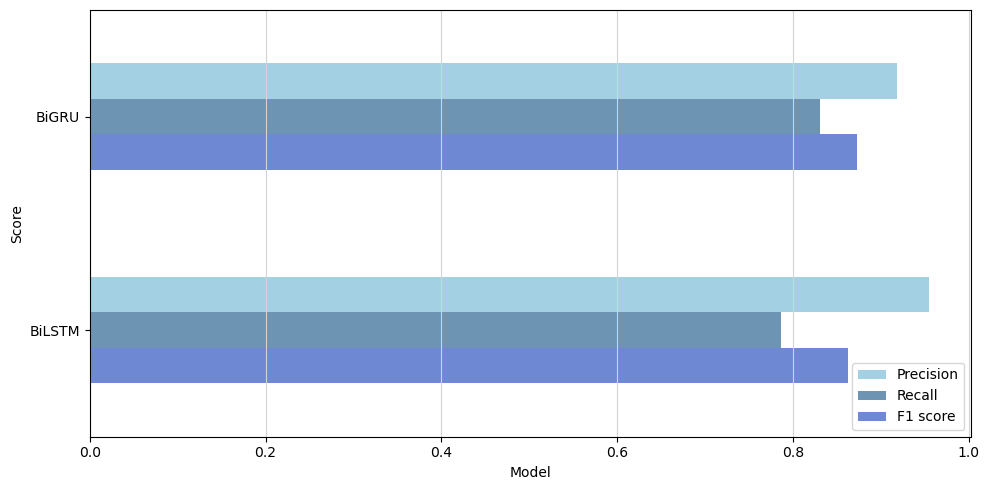

In [324]:
plt.figure(figsize = (10, 5))
plt.grid(color = 'lightgray', axis = 'x')
sns.barplot(y = 'Model', x = 'Score 1', data = result_dl_1, hue = 'Score Type', palette = ['skyblue', 'steelblue', 'royalblue', 'darkblue'], width = 0.5, alpha = 0.85)
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(fontsize = 10)
plt.tight_layout()
plt.show()

#### History

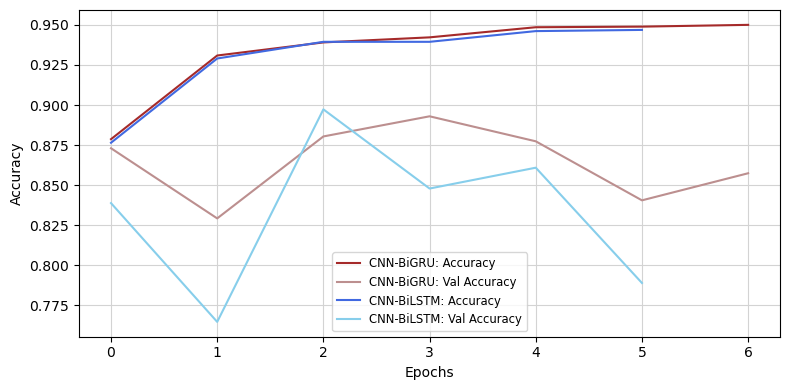

In [307]:
plt.figure(figsize = (8, 4))
plt.grid(color = 'lightgrey', axis = 'both')
plt.plot(history_bigru.history['accuracy'], label = 'CNN-BiGRU: Accuracy', color = 'brown')
plt.plot(history_bigru.history['val_accuracy'], label = 'CNN-BiGRU: Val Accuracy', color = 'rosybrown')
plt.plot(history_bilstm.history['accuracy'], label = 'CNN-BiLSTM: Accuracy', color = 'royalblue')
plt.plot(history_bilstm.history['val_accuracy'], label = 'CNN-BiLSTM: Val Accuracy', color = 'skyblue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize = 'small')
plt.tight_layout()
plt.show()

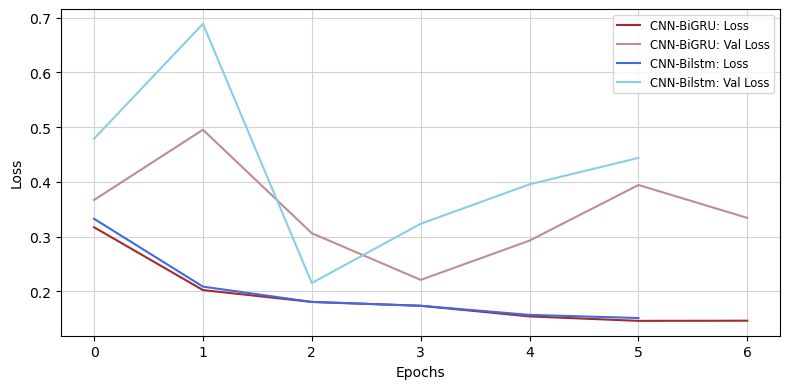

In [216]:
plt.figure(figsize = (8, 4))
plt.grid(color = 'lightgrey', axis = 'both')
plt.plot(history_bigru.history['loss'], label = 'CNN-BiGRU: Loss', color = 'brown')
plt.plot(history_bigru.history['val_loss'], label = 'CNN-BiGRU: Val Loss', color = 'rosybrown')
plt.plot(history_bilstm.history['loss'], label = 'CNN-Bilstm: Loss', color = 'royalblue')
plt.plot(history_bilstm.history['val_loss'], label = 'CNN-Bilstm: Val Loss', color = 'skyblue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize = 'small')
plt.tight_layout()
plt.show()

### Compare accuracy and time of both ML and DL models

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


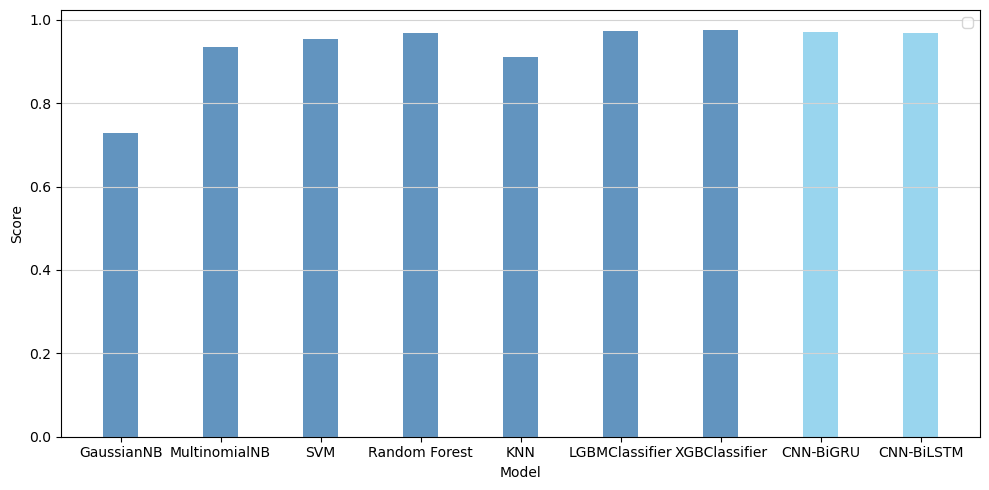

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


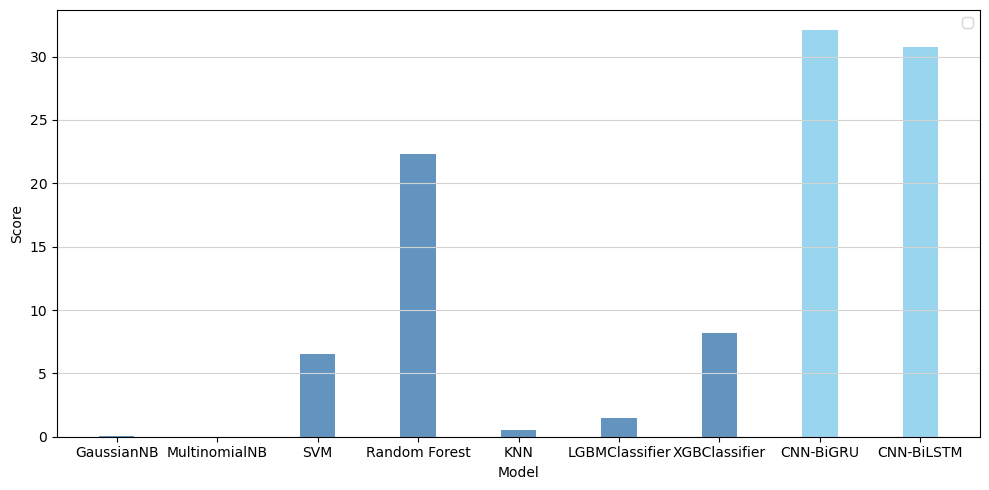

In [328]:
model_name_ml_dl = model_name + ['CNN-BiGRU', 'CNN-BiLSTM']
accuracy_ml_dl = accuracy_ml_c + [test_accuracy_bigru, test_accuracy_bilstm]

plt.figure(figsize = (10, 5))
plt.grid(color = 'lightgray', axis = 'y')
plt.bar(model_name_ml_dl , accuracy_ml_dl, width = 0.35, alpha = 0.85, color = ['steelblue'] * 7 + ['skyblue'] * 2)
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(fontsize = 10)
plt.tight_layout()
plt.show()


time_ml_dl = time_ml_c + [time_bigru, time_bilstm]

plt.figure(figsize = (10, 5))
plt.grid(color = 'lightgray', axis = 'y')
plt.bar(model_name_ml_dl , time_ml_dl, width = 0.35, alpha = 0.85, color = ['steelblue'] * 7 + ['skyblue'] * 2)
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(fontsize = 10)
plt.tight_layout()
plt.show()

### Create confusion matrix of machine learning and deep learning models

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

In [47]:
def create_confusion_matrix(label_true, label_pred):
    mat = confusion_matrix(label_true, label_pred)
    plt.figure(figsize = (6, 6))
    sns.heatmap(mat, fmt = 'd', cmap = 'Blues', alpha = 0.8)
    for i in range(len(mat)):
        for j in range(len(mat[i])):
            plt.text(j + 0.5, i + 0.5, str(mat[i, j]), ha = 'center', va = 'center', color = 'black')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

#### Machine learning models

In [ ]:
i = 0
for p in predictions_ml_c:
    print(p)
    create_confusion_matrix(label_test_combined, predictions_ml_c[p])
    i += 1

In [ ]:
i = 0
for p in predictions_ml:
    print(p)
    create_confusion_matrix(label_test_weighted, predictions_ml[p])
    i += 1

#### Deep learning models

In [ ]:
create_confusion_matrix(label_test_combined, predictions_bigru)

In [ ]:
create_confusion_matrix(label_test_combined, predictions_bilstmu)

### Deep Learning model for text generation

#### Collect data

In [52]:
spam_text = df[df['label'] == 'spam']['text']

#### Preprocess data

In [53]:
_, preprocessed_spam_text = preprocess_text(spam_text)

#### Word2Vec

In [54]:
word2vec_model_gt = Word2Vec(sentences = preprocessed_spam_text, vector_size = 100, window = 5, min_count = 1, workers = 5)
preprocessed_spam_vector = []
target_word = []
max_length = max(len(seq) for seq in preprocessed_spam_text)
for seq in preprocessed_spam_text:
    seq_wv = []
    for word in seq:
        if word in word2vec_model_gt.wv:
            word_vec = word2vec_model_gt.wv[word]
        else: 
            word_vec = [0] * 100
        seq_wv.append(word_vec)
    preprocessed_spam_vector.append(seq_wv)

##### Vocabulary size

In [55]:
vocab_n = len(word2vec_model_gt.wv.index_to_key)

In [56]:
preprocessed_spam_word = [word for sublist in preprocessed_spam_text for word in sublist]

#### Split data into inputs and targets through iterating words in each sentence

In [57]:
max_length = max(len(seq) for seq in preprocessed_spam_text)

In [58]:
input_vector = []
target_index = []
for seq in preprocessed_spam_vector:
    for i in range(1, len(seq) + 1):
        seq_vec = seq[0: i]
        target_word = preprocessed_spam_word[i]
        target_i = word2vec_model_gt.wv.key_to_index[target_word]
        target_index.append(target_i)
        
        if len(seq_vec) < max_length:
            seq_vec = [[0] * 100] * (max_length - len(seq_vec)) + seq_vec

        input_vector.append(seq_vec)

In [59]:
input_vector = np.array(input_vector)
target_index = np.array(target_index)

#### BiLSTM-Attention text generation model building

In [60]:
from tensorflow.keras.layers import LeakyReLU

In [268]:
def build_bilstm_model_gt(hp):
    
    inputs = Input(shape = (input_vector.shape[1], input_vector.shape[2]))
    lstm1 = Bidirectional(LSTM(units = hp.Choice('units', values = [128, 256]), dropout = hp.Choice('dr', values = [0.2, 0.3, 0.4]), recurrent_dropout = hp.Choice('rdr', values = [0.2, 0.3, 0.4]), activation = LeakyReLU(alpha = 0.1), return_sequences = False))(inputs)
    attention = Attention()([lstm1, lstm1])
    concatenate = Concatenate()([lstm1, attention])
    dense = Dense(units = hp.Choice('units2', values = [32, 64, 128]), activation = LeakyReLU(alpha = 0.1))(concatenate)
    layernorm = LayerNormalization()(dense)
    dropout = Dropout(hp.Choice('dr2', values = [0.2, 0.3, 0.4]))(layernorm)
    outputs = Dense(units = vocab_n , activation = 'softmax')(dropout)
    model = Model(inputs = inputs, outputs = outputs)

    optimizer_choice = hp.Choice('optimizer', values = ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta'])
    
    if optimizer_choice == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice('lr_adam', values = [0.001, 0.01]))
    elif optimizer_choice == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = hp.Choice('lr_rmsprop', values = [0.001, 0.01]))
    elif optimizer_choice == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate = hp.Choice('lrsgd', values = [0.001, 0.01]))
    elif optimizer_choice == 'adagrad':
            optimizer = tf.keras.optimizers.Adagrad(learning_rate = hp.Choice('lr_adagrad', values = [0.001, 0.01]))
    else:
            optimizer = tf.keras.optimizers.Adadelta(learning_rate = hp.Choice('lr adadelta', values = [0.001, 0.01]))
    
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model

In [282]:
def hp_tuning_build_best_model_gt(model_function, name, data_train, label_train):
    tuner = RandomSearch(
        model_function,
        objective = 'val_accuracy',
        max_trials = 10,
        executions_per_trial = 1,
        directory = 'my_dir',
        project_name = name)

    tuner.search(data_train, label_train, epochs = 3, validation_split = 0.3)

    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

    model = tuner.hypermodel.build(best_hps)

    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 3)

    history = model.fit(data_train, label_train, epochs = 20, validation_split = 0.3, callbacks = [es])

    train_loss, train_accuracy =  model.evaluate(data_train, label_train)

    return model, best_hps, history, train_loss, train_accuracy

In [ ]:
np.random.seed(30)
tf.random.set_seed(30)
rn.seed(30)

model_bilstm_gt, best_hps_bilstm_gt, history_bilstm_gt, train_loss_bilstm_gt, train_accuracy_bilstm_gt = hp_tuning_build_best_model_gt(build_bilstm_model_gt, 'bilstm_attention_model', input_vector, target_index)

In [ ]:
model_bilstm_gt.get_config()

#### Training process visualization

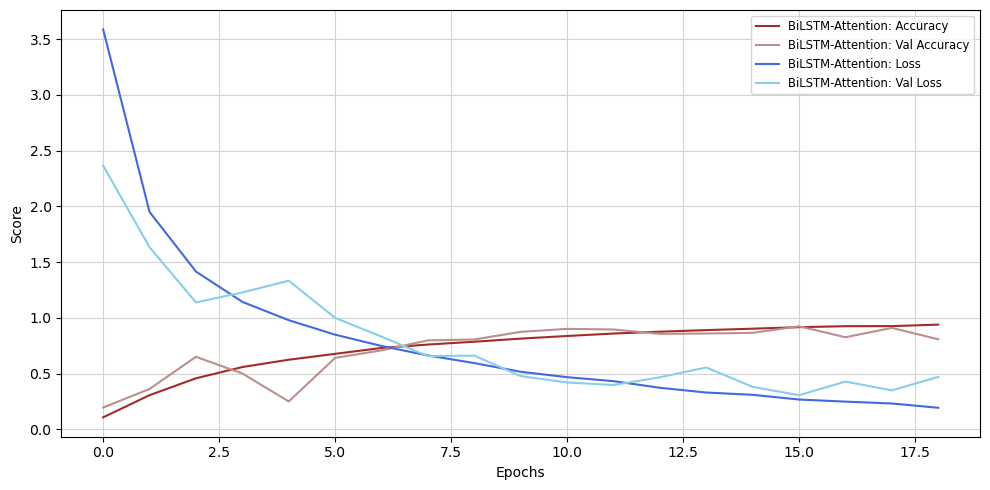

In [284]:
plt.figure(figsize = (10, 5))
plt.grid(color = 'lightgrey', axis = 'both')
plt.plot(history_bilstm_gt.history['accuracy'], label = 'BiLSTM-Attention: Accuracy', color = 'brown')
plt.plot(history_bilstm_gt.history['val_accuracy'], label = 'BiLSTM-Attention: Val Accuracy', color = 'rosybrown')
plt.plot(history_bilstm_gt.history['loss'], label = 'BiLSTM-Attention: Loss', color = 'royalblue')
plt.plot(history_bilstm_gt.history['val_loss'], label = 'BiLSTM-Attention: Val Loss', color = 'skyblue')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend(fontsize = 'small')
plt.tight_layout()
plt.show()

#### Generate samples

In [ ]:
generated_sample = []
for _ in range(100):
    i = rn.randint(0, input_vector.shape[0] - 1)
    input_index = input_vector[i:i + 1]

    generated_text = []
    for _ in range(30):

        output_list = model_bilstm_gt.predict(input_index)
        output_index = np.argmax(output_list)
        output_word = word2vec_model_gt.wv.index_to_key[output_index]

        generated_text.append(output_word)

        word_vec = word2vec_model_gt.wv[output_word]
        word_vec = word_vec.reshape(1, 1, 100)
        input_index = np.concatenate((input_index, word_vec), axis = 1)
                
        input_index = input_index[:, 1:, :]
    generated_sample.append(generated_text)

In [ ]:
generated_sample

### Classify generated samples by models built previously

#### Apply TF-IDF and Word2Vec to extract features

##### TF-IDF

In [286]:
generated_sample_t = [' '.join(sublist) for sublist in generated_sample]
generated_sample_tfidf = tfidf_model.transform(generated_sample_t)
generated_sample_tfidf = generated_sample_tfidf.toarray()

##### Word2Vec

In [287]:
generated_sample_wv = np.array([np.mean([word2vec_model.wv[word] for word in seq if word in word2vec_model.wv] or [np.zeros(100)], axis = 0) for seq in generated_sample])

##### Concatenate features

In [288]:
generated_sample_combined = np.concatenate((generated_sample_tfidf, generated_sample_wv), axis = 1)

In [289]:
generated_sample_combined_3d = generated_sample_combined.reshape(generated_sample_combined.shape[0], 1, generated_sample_combined.shape[1])

#### Predict samples

In [290]:
label_gs = [1] * 100

In [291]:
model_name_gs = ['GaussianNB', 'MultinomialNB', 'SVM', 'Random Forest', 'KNN', 
              'LGBMClassifier', 'XGBClassifier']

predictions_gs = {}
accuracy_gs = {}

i = 0
for mn, m in model_dict_c.items():
    predictions = m.predict(generated_sample_combined)
    predictions_gs[model_name_gs[i]] = predictions
    accuracy = accuracy_score(predictions, label_gs)
    accuracy_gs[model_name[i]] = accuracy
    i += 1

In [ ]:
predictions_bigru_gs = model_bigru.predict(generated_sample_combined_3d)
predictions_bigru_gs = (predictions_bigru_gs > 0.5).astype(int)

predictions_bilstm_gs = model_bilstm.predict(generated_sample_combined_3d)
predictions_bilstm_gs = (predictions_bilstm_gs > 0.5).astype(int)

accuracy_gs['BiGRU'] = accuracy_score(predictions_bigru_gs, label_gs)
accuracy_gs['BiLSTM'] = accuracy_score(predictions_bilstm_gs, label_gs)

#### Visualize results

In [293]:
accuracy_list_gs = accuracy_gs.values()
model_list_gs = accuracy_gs.keys()

In [ ]:
plt.figure(figsize = (10, 5))
plt.grid(color = 'lightgray', axis = 'y')
plt.scatter(model_list_gs, accuracy_list_gs, cmap = 'blue', alpha = 0.8, s = 150)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()